In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras import optimizers
from sklearn.model_selection import train_test_split
# import segmentation_models as sm
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imsave
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from itertools import cycle
from scipy.stats import pearsonr

Using TensorFlow backend.


In [0]:
#Download the dataset
!wget https://zenodo.org/record/3757476/files/COVID-19-CT-Seg_20cases.zip?download=1
!wget https://zenodo.org/record/3757476/files/Lung_and_Infection_Mask.zip?download=1

--2020-06-10 15:45:36--  https://zenodo.org/record/3757476/files/COVID-19-CT-Seg_20cases.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1105395143 (1.0G) [application/octet-stream]
Saving to: ‘COVID-19-CT-Seg_20cases.zip?download=1’

COVID-19-CT-Seg_20c 100%[===================>]   1.03G  7.28MB/s    in 2m 52s  

2020-06-10 15:48:29 (6.14 MB/s) - ‘COVID-19-CT-Seg_20cases.zip?download=1’ saved [1105395143/1105395143]

--2020-06-10 15:48:32--  https://zenodo.org/record/3757476/files/Lung_and_Infection_Mask.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11714838 (11M) [application/octet-stream]
Saving to: ‘Lung_and_Infection_Mask.zip?download=1’

Lung_and_Infection_ 100%[===================>]  11

In [0]:
#Rename zip file
!mv COVID-19-CT-Seg_20cases.zip?download=1 COVID-19-CT-Seg_20cases.zip
!mv Lung_and_Infection_Mask.zip?download=1 Lung_and_Infection_Mask.zip

In [0]:
#extract data 
!mkdir images && unzip COVID-19-CT-Seg_20cases.zip -d images
!mkdir masks && unzip Lung_and_Infection_Mask.zip -d masks
!mkdir training_data
!rm images/ReadMe.txt


Archive:  COVID-19-CT-Seg_20cases.zip
  inflating: images/coronacases_001.nii.gz  
  inflating: images/coronacases_002.nii.gz  
  inflating: images/coronacases_003.nii.gz  
  inflating: images/coronacases_004.nii.gz  
  inflating: images/coronacases_005.nii.gz  
  inflating: images/coronacases_006.nii.gz  
  inflating: images/coronacases_007.nii.gz  
  inflating: images/coronacases_008.nii.gz  
  inflating: images/coronacases_009.nii.gz  
  inflating: images/coronacases_010.nii.gz  
  inflating: images/radiopaedia_10_85902_1.nii.gz  
  inflating: images/radiopaedia_10_85902_3.nii.gz  
  inflating: images/radiopaedia_14_85914_0.nii.gz  
  inflating: images/radiopaedia_27_86410_0.nii.gz  
  inflating: images/radiopaedia_29_86490_1.nii.gz  
  inflating: images/radiopaedia_29_86491_1.nii.gz  
  inflating: images/radiopaedia_36_86526_0.nii.gz  
  inflating: images/radiopaedia_40_86625_0.nii.gz  
  inflating: images/radiopaedia_4_85506_1.nii.gz  
  inflating: images/radiopaedia_7_85703_0.nii

In [0]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1
def imgNorm(img):
  div = np.max(img) - np.min(img)

  return 255*(img - np.min(img))/div


def oneHotMask(mask, cataNum=4):
  shape = mask.shape
  shape = list(shape)
  shape.append(cataNum)
  result = np.zeros(shape)
  # print(np.max(mask))
  for i in range(cataNum):
    temp = np.zeros(mask.shape)
    temp[mask==i] = 1
    result[:,:,i] = temp
  return result

def pre_processing(imgPath, gtPath, opPath, normalize=True, oneHot=True, newSize=[IMG_WIDTH,IMG_HEIGHT], cataNum=4):
  """
  the ouput png file will be store in folder 'img' and 'label' under given opPath

  @param imgPath: folder containing the input nifti file
  @param gtPath: folder contatining the groud truth nifti file
  @param opPath: output folder
  @param normalize: normalize the input or not
  @param oneHot: convert the mask to one hot image or not
  @param newSize: the size of the ouput img/label
  @param cataNum: number of catagories for mask

  example:
  imgPath = './COVID-19-CT-Seg_20cases/'
  gtPath = './Lung_and_Infection_Mask/'
  savePath = './processed/'
  pre_processing(imgPath, gtPath, savePath)

  """
  imgFile = imgPath
  gtFile = gtPath
  savePath = opPath

  gtList = os.listdir(gtFile)

  opImgPath = os.path.join(savePath,'img/')
  opGtPath = os.path.join(savePath,'label/')


  if not os.path.isdir(savePath):
    os.mkdir(savePath)
  if not os.path.isdir(opImgPath):
    os.mkdir(opImgPath)
  if not os.path.isdir(opGtPath):
    os.mkdir(opGtPath)

  studyNum = len(gtList)

  for i in range(studyNum):
    gt = nib.load(gtFile + gtList[i]).get_fdata()
    img = nib.load(imgFile + gtList[i]).get_fdata()

    slices = img.shape[2]
    for s in range(slices):
      if oneHot:
        gtTemp = oneHotMask(gt[:,:,s], cataNum=cataNum)
      else:
        gtTemp = gt[:,:,s]
      gtTemp = resize(gtTemp, newSize, preserve_range=True)
      gtTemp = gtTemp.astype(np.uint8)
      imgTemp = resize(img[:,:,s], newSize, preserve_range=True)
      imgTemp = imgNorm(imgTemp)
      imgTemp = imgTemp.astype(np.uint8)
      gtName = 'case_' + str(i) + '_slices_' + str(s) + '.png'
      imgName = 'case_' + str(i) + '_slices_' + str(s) + '.png'
      imsave(opImgPath+imgName, imgTemp, check_contrast=False)
      imsave(opGtPath+gtName, gtTemp, check_contrast=False)

  return

In [0]:
#load data
images_filepath = sorted(os.listdir('images'))
masks_filepath = sorted(os.listdir('masks'))
print(images_filepath)
print(images_filepath)

current_path = os.getcwd()
images_folder_path = os.path.join(current_path,"images/")
masks_folder_path = os.path.join(current_path,"masks/")
training_data_path = os.path.join(current_path,"training_data/")
print(images_folder_path)
print(masks_folder_path)
# train_list = np.empty((0,512, 512, 1), dtype=np.uint8)
# sum = 0
# for image_filepath, mask_filepath in zip(images_filepath, masks_filepath):
  # if sum == 2:
  #   break
  # image_file = os.path.join(images_folder_path, image_filepath) 
  # image = nib.load(image_file)
  # image_data = image.get_fdata()
  # image_data = np.asarray(image_data,dtype=np.uint8)
  # image_data = np.swapaxes(image_data,0,2)
  # image_data_tmp = resize(image_data[])
  # image_data = np.expand_dims(image_data,axis=-1)
  # sum += image_data.shape[2]
  # print(image_data.shape)

  # mask_file = os.path.join(masks_folder_path, mask_filepath)
  # mask = nib.load(mask_file)
  # mask_data = mask.get_fdata()
  # print(mask_data.shape)

  # train_list = np.concatenate((train_list,image_data))
# print(train_list.shape)
# print(sum)

# pre_processing(images_folder_path,masks_folder_path,training_data_path)

['coronacases_001.nii.gz', 'coronacases_002.nii.gz', 'coronacases_003.nii.gz', 'coronacases_004.nii.gz', 'coronacases_005.nii.gz', 'coronacases_006.nii.gz', 'coronacases_007.nii.gz', 'coronacases_008.nii.gz', 'coronacases_009.nii.gz', 'coronacases_010.nii.gz', 'radiopaedia_10_85902_1.nii.gz', 'radiopaedia_10_85902_3.nii.gz', 'radiopaedia_14_85914_0.nii.gz', 'radiopaedia_27_86410_0.nii.gz', 'radiopaedia_29_86490_1.nii.gz', 'radiopaedia_29_86491_1.nii.gz', 'radiopaedia_36_86526_0.nii.gz', 'radiopaedia_40_86625_0.nii.gz', 'radiopaedia_4_85506_1.nii.gz', 'radiopaedia_7_85703_0.nii.gz']
['coronacases_001.nii.gz', 'coronacases_002.nii.gz', 'coronacases_003.nii.gz', 'coronacases_004.nii.gz', 'coronacases_005.nii.gz', 'coronacases_006.nii.gz', 'coronacases_007.nii.gz', 'coronacases_008.nii.gz', 'coronacases_009.nii.gz', 'coronacases_010.nii.gz', 'radiopaedia_10_85902_1.nii.gz', 'radiopaedia_10_85902_3.nii.gz', 'radiopaedia_14_85914_0.nii.gz', 'radiopaedia_27_86410_0.nii.gz', 'radiopaedia_29_86

In [0]:
pre_processing(images_folder_path,masks_folder_path,training_data_path)

In [0]:
images_filepath = sorted(os.listdir(training_data_path + '/img'))
masks_filepath = sorted(os.listdir(training_data_path + '/label'))

print(images_filepath)
print(masks_filepath)
print(len(images_filepath))

['case_0_slices_0.png', 'case_0_slices_1.png', 'case_0_slices_10.png', 'case_0_slices_100.png', 'case_0_slices_101.png', 'case_0_slices_102.png', 'case_0_slices_103.png', 'case_0_slices_104.png', 'case_0_slices_105.png', 'case_0_slices_106.png', 'case_0_slices_107.png', 'case_0_slices_108.png', 'case_0_slices_109.png', 'case_0_slices_11.png', 'case_0_slices_110.png', 'case_0_slices_111.png', 'case_0_slices_112.png', 'case_0_slices_113.png', 'case_0_slices_114.png', 'case_0_slices_115.png', 'case_0_slices_116.png', 'case_0_slices_117.png', 'case_0_slices_118.png', 'case_0_slices_119.png', 'case_0_slices_12.png', 'case_0_slices_120.png', 'case_0_slices_121.png', 'case_0_slices_122.png', 'case_0_slices_123.png', 'case_0_slices_124.png', 'case_0_slices_125.png', 'case_0_slices_126.png', 'case_0_slices_127.png', 'case_0_slices_128.png', 'case_0_slices_129.png', 'case_0_slices_13.png', 'case_0_slices_130.png', 'case_0_slices_131.png', 'case_0_slices_132.png', 'case_0_slices_133.png', 'case_0

In [0]:
# images_filepath = sorted(os.listdir(training_data_path + '/img'))
# masks_filepath = sorted(os.listdir(training_data_path + '/label'))

# train_list = []
# mask_list = []
# count1 = 0
# count2 = 0
X_train = np.zeros((3520, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
Y_train = np.zeros((3520, IMG_HEIGHT, IMG_WIDTH, 4), dtype=np.uint8)
i = 0

for img, mask in zip(images_filepath, masks_filepath):
  train = imread(training_data_path + "img/" + img)
  train = np.expand_dims(train, axis=-1)
  X_train[i] = train

  mas = imread(training_data_path + "label/" + mask)
  Y_train[i] = mas
  i+=1
  # print(training_data_path + "img/" + i)
  # print(mask_list[0].shape)

# print(count1)
# print(count2)
# print(nask_list[0].shape)
# X_train = np.zeros((3520, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
# Y_train = np.zeros((3520, IMG_HEIGHT, IMG_WIDTH, 4), dtype=np.uint8)
# print(X_train.shape)
# print(Y_train.shape)
# for img, msk in zip(train_list, mask_list):
#     img = np.expand_dims(img, axis=-1)
#     X_train[i] = img

#     # mask = np.expand_dims(msk,axis=-1)
#     # t1 = 0
#     # m = m/255
#     # mask[mask > t1] = 1
#     # mask[mask <= t1] = 0
#     Y_train[i] = msk

#     i += 1


In [0]:
#split train, val, test dataset
seed = 42
random.seed = seed
np.random.seed = seed
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1/9, random_state=42)

In [0]:
ix = 10
print(np.sum(y_train[ix], axis=-1))

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


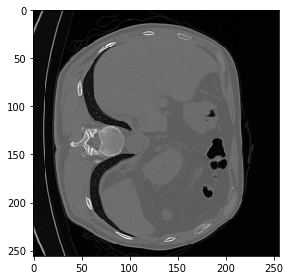

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


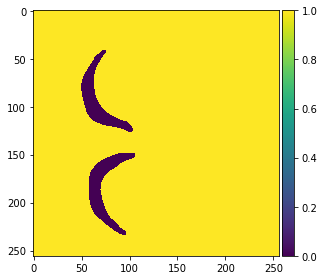

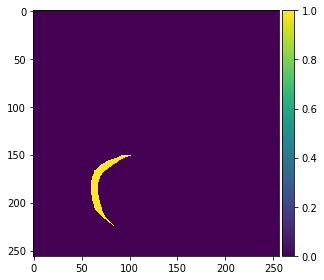

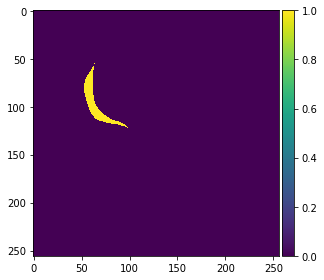

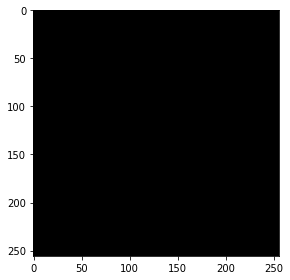

(256, 256, 1)

In [0]:
ix = 25
imshow(x_train[ix,:,:,0])
plt.show()
imshow(np.squeeze(y_train[ix,:,:,0]))
plt.show()
imshow(np.squeeze(y_train[ix,:,:,1]))
plt.show()
imshow(np.squeeze(y_train[ix,:,:,2]))
plt.show()
imshow(np.squeeze(y_train[ix,:,:,3]))
plt.show()
X_train[ix].shape

In [0]:
#IOU metrics
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [0]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score
 
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
 
#ComboLoss
 
def Tversky_Loss(y_true, y_pred, smooth = 1, alpha = 0.3, beta = 0.7, flatten = False):
    
    if flatten:
        y_true = K.flatten(y_true)
        y_pred = K.flatten(y_pred)
    
    TP = K.sum(y_true * y_pred)
    FP = K.sum((1-y_true) * y_pred)
    FN = K.sum(y_true * (1-y_pred))
    
    tversky_coef = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    
    return 1 - tversky_coef
 
def Focal_Loss(y_true, y_pred, alpha = 0.8, gamma = 2.0, flatten = False):
    
    if flatten:
        y_true = K.flatten(y_true)
        y_pred = K.flatten(y_pred)    
    
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    bce_exp = K.exp(-bce)
    
    loss = K.mean(alpha * K.pow((1-bce_exp), gamma) * bce)
    return loss
 
def weighted_bce(weight = 0.6):
    
    def convert_2_logits(y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        return tf.math.log(y_pred / (1-y_pred))
    
    def weighted_binary_crossentropy(y_true, y_pred):
        y_pred = convert_2_logits(y_pred)
        loss = tf.nn.weighted_cross_entropy_with_logits(logits = y_pred, labels = y_true, pos_weight = weight)
        return loss
    
    return weighted_binary_crossentropy
 
def Combo_Loss(y_true, y_pred, a = 0.4, b = 0.2, c= 0.4):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    return a*weighted_bce()(y_true, y_pred) + b*Focal_Loss(y_true_f, y_pred_f) + c*Tversky_Loss(y_true_f, y_pred_f)
 
def Dice_coef(y_true, y_pred, smooth = 1):
 
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
 
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
 
def Dice_loss(y_true, y_pred):   
    return  1.0 - Dice_coef(y_true, y_pred)
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [0]:
# Build U-Net model
num_filters = 16
inputs = Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)
c1 = Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
b11 = BatchNormalization(axis=3)(c1)
c1 = Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (b11)
b12 = BatchNormalization(axis=3)(c1)
p1 = MaxPooling2D((2, 2)) (b12)
# d1 = Dropout(0.3) (p1)


c2 = Conv2D(num_filters*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
b21 = BatchNormalization(axis=3)(c2)
# c2 = Dropout(0.1) (c2)
c2 = Conv2D(num_filters*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (b21)
b22 = BatchNormalization(axis=3)(c2)
p2 = MaxPooling2D((2, 2)) (b22)
# d2 = Dropout(0.3) (p2)

c3 = Conv2D(num_filters*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
b31 = BatchNormalization(axis=3)(c3)
c3 = Conv2D(num_filters*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (b31)
# b32 = BatchNormalization(axis=3)(c3)
p3 = MaxPooling2D((2, 2)) (c3)
# d3 = Dropout(0.3) (p3)

c4 = Conv2D(num_filters*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
b41 = BatchNormalization(axis=3)(c4)
c4 = Conv2D(num_filters*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (b41)
# b42 = BatchNormalization(axis=3)(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
# d4 = Dropout(0.3) (p4)

c5 = Conv2D(num_filters*16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
b51 = BatchNormalization(axis=3)(c5)
c5 = Conv2D(num_filters*16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (b51)
# b52 = BatchNormalization(axis=3)(c5)
d5 = Dropout(0.5) (c5)

u6 = Conv2DTranspose(num_filters*8, (2, 2), strides=(2, 2), padding='same') (d5)
u6 = concatenate([u6, c4])
c6 = Conv2D(num_filters*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
# b6 = BatchNormalization(axis=3)(c6)
c6 = Conv2D(num_filters*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)
# d6 = Dropout(0.3) (c6)

u7 = Conv2DTranspose(num_filters*4, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(num_filters*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
# b7 = BatchNormalization(axis=3)(c7)
c7 = Conv2D(num_filters*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)
# d7 = Dropout(0.3) (c7)



u8 = Conv2DTranspose(num_filters*2, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(num_filters*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
# b8 = BatchNormalization(axis=3)(c8)
c8 = Conv2D(num_filters*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)
# d8 = Dropout(0.3) (c8)


u9 = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
# b9 = BatchNormalization(axis=3)(c9)
c9 = Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)
# d9 = Dropout(0.3) (c9)

outputs = Conv2D(4, (1, 1), activation='softmax') (c9)
opt = optimizers.Adam(lr=1E-4)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=opt, loss= 'categorical_crossentropy', metrics= [dice_coef])
# model.compile(optimizer=opt, loss= 'categorical_crossentropy', metrics= ['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 256, 256, 1)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 256, 256, 16) 160         lambda_3[0][0]                   
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 256, 256, 16) 64          conv2d_39[0][0]                  
____________________________________________________________________________________________

In [0]:
# #training function
# # checkpointer = ModelCheckpoint('unet_model_.h5', verbose=1, save_best_only=True)
# # results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=60)
# from datetime import datetime

# date_str = datetime.today().strftime('%Y-%m-%d-%H:%M')
# # print(date_str)
# !mkdir /content/drive/My\ Drive/ssi_project/$date_str
# save_path = "/content/drive/My Drive/ssi_project/" + date_str
# # print(save_path)
# file_path = save_path + "/weights.hdf5"
# checkpointer = ModelCheckpoint(file_path, verbose=1, save_best_only=True, mode='max')
# early_stop = tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')
# results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=32, epochs=30, callbacks=[checkpointer,early_stop])
early_stop = tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')

results = model.fit(x_train, y_train, batch_size=16, epochs=60,validation_data=(x_val,y_val),verbose = 1, callbacks=[early_stop])

Train on 2816 samples, validate on 352 samples
Epoch 1/60
2816/2816 [==============================] - 26s 9ms/step - loss: 0.2440 - dice_coef: 0.8379 - val_loss: 0.3870 - val_dice_coef: 0.9057
Epoch 2/60
2816/2816 [==============================] - 24s 9ms/step - loss: 0.0896 - dice_coef: 0.9176 - val_loss: 0.2964 - val_dice_coef: 0.9117
Epoch 3/60
2816/2816 [==============================] - 24s 9ms/step - loss: 0.0355 - dice_coef: 0.9513 - val_loss: 0.0502 - val_dice_coef: 0.9571
Epoch 4/60
2816/2816 [==============================] - 24s 9ms/step - loss: 0.0186 - dice_coef: 0.9603 - val_loss: 0.0144 - val_dice_coef: 0.9715
Epoch 5/60
2816/2816 [==============================] - 24s 9ms/step - loss: 0.0144 - dice_coef: 0.9622 - val_loss: 0.0116 - val_dice_coef: 0.9719
Epoch 6/60
2816/2816 [==============================] - 24s 9ms/step - loss: 0.0117 - dice_coef: 0.9632 - val_loss: 0.0096 - val_dice_coef: 0.9732
Epoch 7/60
2816/2816 [==============================] - 24s 9ms/step - 

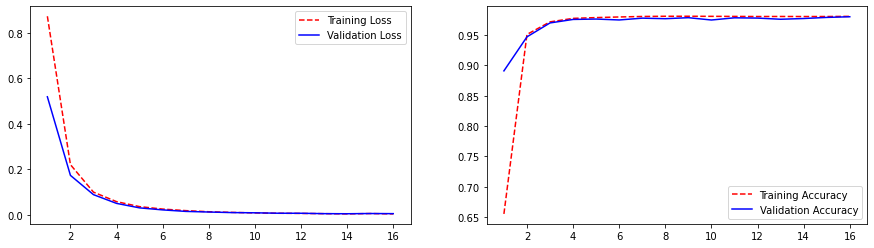

In [0]:
#plot the training progress
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_loss = results.history['loss']
validation_loss = results.history['val_loss']

training_accuracy = results.history['accuracy']
validation_accuracy = results.history['val_accuracy']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epoch_count, training_accuracy, 'r--')
axs[1].plot(epoch_count, validation_accuracy, 'b-')
axs[1].legend(['Training Accuracy', 'Validation Accuracy'])

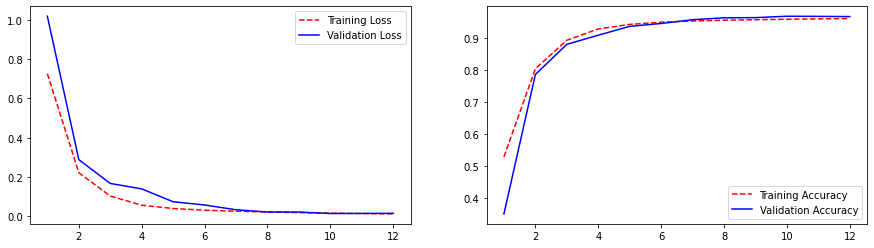

In [0]:
#plot the training progress
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

training_loss = results.history['loss']
validation_loss = results.history['val_loss']

training_accuracy = results.history['dice_coef']
validation_accuracy = results.history['val_dice_coef']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epoch_count, training_accuracy, 'r--')
axs[1].plot(epoch_count, validation_accuracy, 'b-')
axs[1].legend(['Training Accuracy', 'Validation Accuracy'])

In [0]:
filepath = "/content/drive/My Drive/ssi_project/trained_model/original_unet/"
model.save(filepath + "dice_metric_64.h5")

In [0]:
# import keras.losses
# keras.losses.Combo_Loss = Combo_Loss

filepath = "/content/drive/My Drive/ssi_project/trained_model/original_unet/"
# model = tf.keras.models.load_model(filepath + 'dice_metric.h5')
# model = load_model(filepath + 'final_crossentropy.h5', custom_objects={'dice_coef':dice_coef})
model = load_model(filepath + 'dice_metric_64.h5', custom_objects={'dice_coef':dice_coef})

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 640         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
____________________________________________________________________________________________

In [0]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(x_test, y_test, batch_size=352)
print('test loss, test acc:', results)
# print(model.metrics_names)


# Evaluate on test data


ResourceExhaustedError: ignored

In [0]:
def roc_preprocess(pred):
    """
    Convert pred mask from [256,256,4] to [1,256,256,4]
    @param pred: prediction mask of shape [256,256,4]

    @return mask_pred: prediction mask of shape [1,256,256,4]
    """
    mask_pred = pred
    mask_pred = np.expand_dims(mask_pred,axis=-1)
    mask_pred = np.swapaxes(mask_pred,2,3)
    mask_pred = np.swapaxes(mask_pred,1,2)
    mask_pred = np.swapaxes(mask_pred,0,1)

    return mask_pred

In [0]:
#draw ROC curve 
def draw_roc_curve(gt,pred,multi=False,num_class = 4):
    """
    Draw ROC curve for each class
    
    @param gt: ground truth mask(s) of shape [num_masks, image_width, image_height, num_classes]
    @param pred: prediction mask(s) of shape [num_masks, image_width, image_height, num_classes]
    @param multi: False to draw roc curve for 1 image. True to draw for multi images
    @param num_class: number of classes

    example:
    preds = model.predict(x_test,verbose = 1)
    gts = y_test
    draw_roc_curve(gts,preds,multi=True)
    """

    
    if multi:
        if gt.ndim != 4 or pred.ndim != 4:
            print("Dimension of gt and pred must be 4 for drawing multi images curve!")
            return

        num_test_samples = pred.shape[0]
        gt_sep = np.zeros((num_test_samples,IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
        pred_sep = np.zeros((num_test_samples,IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
    
    else:
        if gt.ndim != 3 or pred.ndim != 4:
            print("Dimension of gt must be 3 and pred must be 4 for drawing single image curve!")
            return

        # gt = np.argmax(gt,axis=-1)
        gt_sep = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
        pred_sep = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
    
    gt = np.argmax(gt,axis=-1)
    pred = np.argmax(pred,axis=-1)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    coef = 0
    p_val = 0
    for i in range(num_class):
        # if i == 0:
        #     gt_sep = np.where(gt == i, 1, 0)
        #     pred_sep = np.where(pred == i, 1, 0)
        # else:
        gt_sep = np.array(gt == i, dtype=np.uint8)
        pred_sep = np.array(pred == i, dtype=np.uint8)
        
        fpr[i], tpr[i], _ = roc_curve(gt_sep.ravel(), pred_sep.ravel())
        roc_auc[i] = auc(fpr[i],tpr[i])
        # print(dc(pred_sep,gt_sep))
        # print(hd(pred_sep,gt_sep))
        # coef,val = pearsonr(gt_sep.flatten(),pred_sep.flatten())
        # print(coef)
        # print(val)
        # bland_altman_plot(gt_sep,pred_sep)
    lw = 2
    plt.figure()
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue','green'])
    classes = ['Background','Left Lung','Right Lung','Infection']
    for i, color in zip(range(num_class), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(classes[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()  


In [0]:
def dc(result, reference):
    r"""
    Dice coefficient
    
    Computes the Dice coefficient (also known as Sorensen index) between the binary
    objects in two images.
    
    The metric is defined as
    
    .. math::
        
        DC=\frac{2|A\cap B|}{|A|+|B|}
        
    , where :math:`A` is the first and :math:`B` the second set of samples (here: binary objects).
    
    Parameters
    ----------
    result : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    reference : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    
    Returns
    -------
    dc : float
        The Dice coefficient between the object(s) in ```result``` and the
        object(s) in ```reference```. It ranges from 0 (no overlap) to 1 (perfect overlap).
        
    Notes
    -----
    This is a real metric. The binary images can therefore be supplied in any order.
    """
    result = np.atleast_1d(result.astype(np.bool))
    reference = np.atleast_1d(reference.astype(np.bool))
    
    intersection = np.count_nonzero(result & reference)
    
    size_i1 = np.count_nonzero(result)
    size_i2 = np.count_nonzero(reference)
    
    try:
        dc = 2. * intersection / float(size_i1 + size_i2)
    except ZeroDivisionError:
        dc = 0.0
    
    return dc

Img shape:  (256, 256, 1)
New img shape:  (1, 256, 256, 1)
GT shape:  (256, 256, 4)
1/1 [==============================] - 0s 82ms/step
Predict shape:  (1, 256, 256, 4)
New Predict shape:  (256, 256)
[0 1 2 3]
New GT shape:  (256, 256)
[0 1 2]


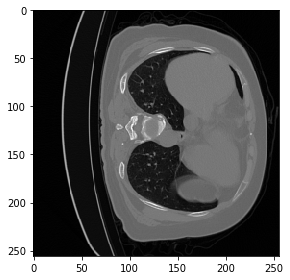

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


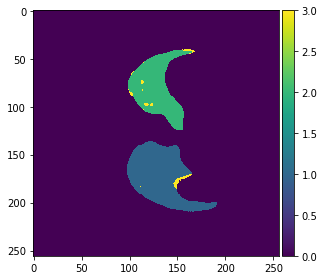

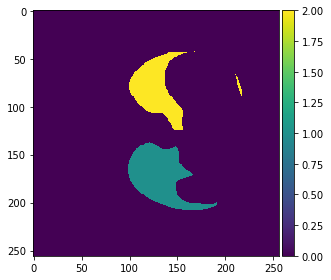

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


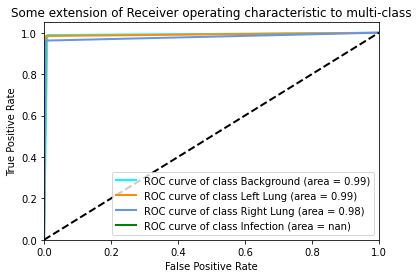

In [81]:
ix = 6
img = x_test[ix]
print("Img shape: ",img.shape)
img = np.expand_dims(img,axis=-1)
img = np.swapaxes(img,2,3)
img = np.swapaxes(img,1,2)
img = np.swapaxes(img,0,1)
print("New img shape: ",img.shape)
gt = y_test[ix]
print("GT shape: ",gt.shape)


preds_train = model.predict(img, verbose=1)
print("Predict shape: ",preds_train.shape)

max_val = np.argmax(preds_train[0,:,:,:], axis=-1)


print("New Predict shape: ",max_val.shape)
print(np.unique(max_val))


combined_gt = np.argmax(gt, axis=-1)
print("New GT shape: ",combined_gt.shape)
print(np.unique(combined_gt))

# draw_roc_curve(gt, preds_train)

imshow(np.squeeze(img[0,:,:,0]))
plt.show()
# imshow(np.squeeze(preds_train[0,:,:,0]))
# plt.show()
# imshow(np.squeeze(preds_train[0,:,:,1]))
# plt.show()
# imshow(np.squeeze(preds_train[0,:,:,2]))
# plt.show()
# imshow(np.squeeze(preds_train[0,:,:,3]))
# plt.show()
imshow(max_val)
plt.show()
imshow(combined_gt)
plt.show()

draw_roc_curve(gt,preds_train)
# if img.ndim != 4 or preds_train.ndim != 4: 
#     print("blobla")
# print(img.ndim)

# a = roc_preprocess(gt)
# print(a.shape)

In [0]:
imgs = x_test
print("Imgs shape:",imgs.shape)

preds = model.predict(imgs, verbose = 1)
print("Preds shape: ",preds.shape)

max_vals = np.argmax(preds, axis=-1)
print("New Predict shape: ",max_vals.shape)
print(np.unique(max_vals))



Imgs shape: (352, 256, 256, 1)
352/352 [==============================] - 10s 28ms/step
Preds shape:  (352, 256, 256, 4)
New Predict shape:  (352, 256, 256)
[0 1 2 3]


In [0]:
gts = y_test
print(gts.shape)
max_gts = np.argmax(gts, axis=-1)
print("New GT shape: ",max_gts.shape)
print(np.unique(max_gts))



(352, 256, 256, 4)
New GT shape:  (352, 256, 256)
[0 1 2 3]


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


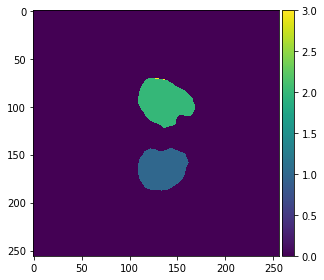

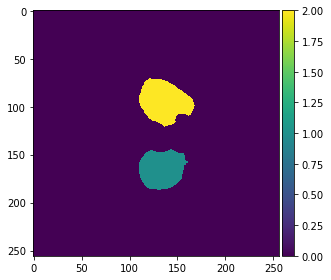

In [0]:
ix = 30
imshow(max_vals[ix,:,:])
plt.show()
imshow(max_gts[ix,:,:])
plt.show()

In [0]:
bin_pred_mask = np.where(max_vals > 0, 1, 0)
bin_test_mask = np.where(max_gts > 0,1,0)
print(dc(bin_pred_mask.flatten(),bin_test_mask.flatten()))

0.8862501775068675


In [0]:
[coef,p_val] = pearsonr(max_gts.flatten(),max_vals.flatten())
print("Pearsonr : " + str(coef) + "     Coef: " + str(p_val))
print(p_val)
print(coef)

Pearsonr : 0.837552347955266     Coef: 0.0
0.0
0.837552347955266


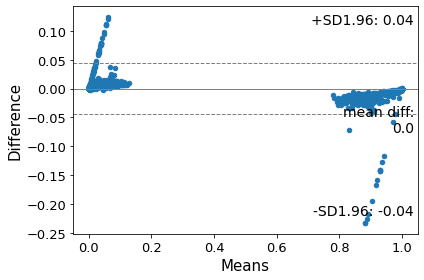

In [0]:
bland_altman_plot(preds,gts)

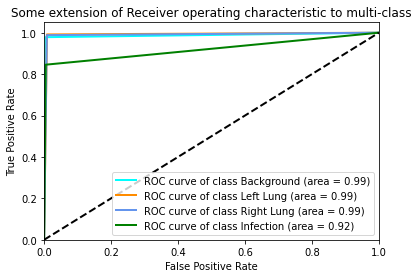

In [0]:
draw_roc_curve(gts,preds,multi=True)

In [0]:
a = nib.load("/content/images/coronacases_004.nii.gz")
print(a.header)

In [0]:
def bland_altman_plot(m1, m2,
                      sd_limit=1.96,
                      ax=None,
                      scatter_kwds=None,
                      mean_line_kwds=None,
                      limit_lines_kwds=None):
    """
    Bland-Altman Plot.
    A Bland-Altman plot is a graphical method to analyze the differences
    between two methods of measurement. The mean of the measures is plotted
    against their difference.
    Parameters
    ----------
    m1, m2: ND array-like [NxHxWx4] One Hot Encoded: [0 1]
    (in our case m1 should be the mask, while, m2 is the prediction)
    sd_limit : float, default 1.96
        The limit of agreements expressed in terms of the standard deviation of
        the differences. If `md` is the mean of the differences, and `sd` is
        the standard deviation of those differences, then the limits of
        agreement that will be plotted will be
                       md - sd_limit * sd, md + sd_limit * sd
        The default of 1.96 will produce 95% confidence intervals for the means
        of the differences.
        If sd_limit = 0, no limits will be plotted, and the ylimit of the plot
        defaults to 3 standard deviatons on either side of the mean.
    ax: matplotlib.axis, optional
        matplotlib axis object to plot on.
    scatter_kwargs: keywords
        Options to to style the scatter plot. Accepts any keywords for the
        matplotlib Axes.scatter plotting method
    mean_line_kwds: keywords
        Options to to style the scatter plot. Accepts any keywords for the
        matplotlib Axes.axhline plotting method
    limit_lines_kwds: keywords
        Options to to style the scatter plot. Accepts any keywords for the
        matplotlib Axes.axhline plotting method
   Returns
    -------
    Plot of Bland Altman
    # ax: matplotlib Axis object
    """
    if(len(m1.shape)==3):

        m1 = np.argmax(m1,axis=2)
        m2 = np.argmax(m2,axis=2)

        # calculate surface areas for each class
        l1 = []
        l2 = []
        for i in range(4):
            l1.append((np.count_nonzero(m1==i))/(m1.shape[0]*m1.shape[1]))
            l2.append((np.count_nonzero(m2==i))/(m1.shape[0]*m1.shape[1]))

    if(len(m1.shape)==4):
        
        m1 = np.argmax(m1,axis=3)
        m2 = np.argmax(m2,axis=3)

        # calculate surface areas for each class
        l1 = []
        l2 = []
        for i in range(4):
            for j in range(m1.shape[0]):
                l1.append((np.count_nonzero(m1[j,...]==i))/(m1.shape[1]*m1.shape[2]))
                l2.append((np.count_nonzero(m2[j,...]==i))/(m1.shape[1]*m1.shape[2]))

    m1 = np.array(l1)
    m2 = np.array(l2)
    
    # Compare the lengths of the samples coming from a two different methods
    if len(m1) != len(m2):
        raise ValueError('m1 does not have the same length as m2.')
    if sd_limit < 0:
        raise ValueError('sd_limit ({}) is less than 0.'.format(sd_limit))
    # Compute the mean of the samples for both of them
    means = np.mean([m1, m2], axis=0)
    # Compute the difference between samples
    diffs = m1 - m2
    # Compute the mean difference between the samples
    mean_diff = np.mean(diffs)
    # Compute the standard deviation of the difference between samples
    std_diff = np.std(diffs, axis=0)

    # Plot Options for nice plot
    if ax is None:
        ax = plt.gca()

    scatter_kwds = scatter_kwds or {}
    if 's' not in scatter_kwds:
        scatter_kwds['s'] = 20
    mean_line_kwds = mean_line_kwds or {}
    limit_lines_kwds = limit_lines_kwds or {}
    for kwds in [mean_line_kwds, limit_lines_kwds]:
        if 'color' not in kwds:
            kwds['color'] = 'gray'
        if 'linewidth' not in kwds:
            kwds['linewidth'] = 1
    if 'linestyle' not in mean_line_kwds:
        kwds['linestyle'] = '--'
    if 'linestyle' not in limit_lines_kwds:
        kwds['linestyle'] = ':'
    # Scatter the means virsus the differences between samples on the plot
    ax.scatter(means, diffs, **scatter_kwds)
    # draw mean line.
    ax.axhline(mean_diff, **mean_line_kwds)  

    # Annotate mean line with mean difference.
    ax.annotate('mean diff:\n{}'.format(np.round(mean_diff, 2)),
                xy=(0.99, 0.5),
                horizontalalignment='right',
                verticalalignment='center',
                fontsize=14,
                xycoords='axes fraction')

    if sd_limit > 0:
        half_ylim = (1.5 * sd_limit) * std_diff
        # ax.set_ylim(mean_diff - half_ylim,
        #             mean_diff + half_ylim)

        limit_of_agreement = sd_limit * std_diff
        lower = mean_diff - limit_of_agreement
        upper = mean_diff + limit_of_agreement
        for j, lim in enumerate([lower, upper]):
            ax.axhline(lim, **limit_lines_kwds)
        ax.annotate('-SD{}: {}'.format(sd_limit, np.round(lower, 2)),
                    xy=(0.99, 0.07),
                    horizontalalignment='right',
                    verticalalignment='bottom',
                    fontsize=14,
                    xycoords='axes fraction')
        ax.annotate('+SD{}: {}'.format(sd_limit, np.round(upper, 2)),
                    xy=(0.99, 0.92),
                    horizontalalignment='right',
                    fontsize=14,
                    xycoords='axes fraction')

    elif sd_limit == 0:
        half_ylim = 3 * std_diff
        # ax.set_ylim(mean_diff - half_ylim,
        #             mean_diff + half_ylim)

    ax.set_ylabel('Difference', fontsize=15)
    ax.set_xlabel('Means', fontsize=15)
    ax.tick_params(labelsize=13)
    plt.tight_layout()
    # plt.savefig("BlandAltman.png")
    # plt.close('all')
    plt.show()
    # return ax

In [0]:
import numpy
from scipy.ndimage import _ni_support
from scipy.ndimage.morphology import distance_transform_edt, binary_erosion,\
    generate_binary_structure
from scipy.ndimage.measurements import label, find_objects
from scipy.stats import pearsonr
import os
import os
import shutil
from time import time

import numpy as np
# import SimpleITK as sitk
import scipy.ndimage as ndimage




def hd(result, reference, voxelspacing=None, connectivity=1):
    """
    Hausdorff Distance.
    
    Computes the (symmetric) Hausdorff Distance (HD) between the binary objects in two
    images. It is defined as the maximum surface distance between the objects.
    
    Parameters
    ----------
    result : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    reference : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    voxelspacing : float or sequence of floats, optional
        The voxelspacing in a distance unit i.e. spacing of elements
        along each dimension. If a sequence, must be of length equal to
        the input rank; if a single number, this is used for all axes. If
        not specified, a grid spacing of unity is implied.
    connectivity : int
        The neighbourhood/connectivity considered when determining the surface
        of the binary objects. This value is passed to
        `scipy.ndimage.morphology.generate_binary_structure` and should usually be :math:`> 1`.
        Note that the connectivity influences the result in the case of the Hausdorff distance.
        
    Returns
    -------
    hd : float
        The symmetric Hausdorff Distance between the object(s) in ```result``` and the
        object(s) in ```reference```. The distance unit is the same as for the spacing of 
        elements along each dimension, which is usually given in mm.
        
    See also
    --------
    :func:`assd`
    :func:`asd`
    
    Notes
    -----
    This is a real metric. The binary images can therefore be supplied in any order.
    """
    hd1 = __surface_distances(result, reference, voxelspacing, connectivity).max()
    hd2 = __surface_distances(reference, result, voxelspacing, connectivity).max()
    hd = max(hd1, hd2)
    return hd


def hd95(result, reference, voxelspacing=None, connectivity=1):
    """
    95th percentile of the Hausdorff Distance.
    Computes the 95th percentile of the (symmetric) Hausdorff Distance (HD) between the binary objects in two
    images. Compared to the Hausdorff Distance, this metric is slightly more stable to small outliers and is
    commonly used in Biomedical Segmentation challenges.
    Parameters
    ----------
    result : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    reference : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    voxelspacing : float or sequence of floats, optional
        The voxelspacing in a distance unit i.e. spacing of elements
        along each dimension. If a sequence, must be of length equal to
        the input rank; if a single number, this is used for all axes. If
        not specified, a grid spacing of unity is implied.
    connectivity : int
        The neighbourhood/connectivity considered when determining the surface
        of the binary objects. This value is passed to
        `scipy.ndimage.morphology.generate_binary_structure` and should usually be :math:`> 1`.
        Note that the connectivity influences the result in the case of the Hausdorff distance.
    Returns
    -------
    hd : float
        The symmetric Hausdorff Distance between the object(s) in ```result``` and the
        object(s) in ```reference```. The distance unit is the same as for the spacing of 
        elements along each dimension, which is usually given in mm.
    See also
    --------
    :func:`hd`
    Notes
    -----
    This is a real metric. The binary images can therefore be supplied in any order.
    """
    hd1 = __surface_distances(result, reference, voxelspacing, connectivity)
    hd2 = __surface_distances(reference, result, voxelspacing, connectivity)
    hd95 = numpy.percentile(numpy.hstack((hd1, hd2)), 95)
    return hd95


def assd(result, reference, voxelspacing=None, connectivity=1):
    """
    Average symmetric surface distance.
    
    Computes the average symmetric surface distance (ASD) between the binary objects in
    two images.
    
    Parameters
    ----------
    result : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    reference : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    voxelspacing : float or sequence of floats, optional
        The voxelspacing in a distance unit i.e. spacing of elements
        along each dimension. If a sequence, must be of length equal to
        the input rank; if a single number, this is used for all axes. If
        not specified, a grid spacing of unity is implied.
    connectivity : int
        The neighbourhood/connectivity considered when determining the surface
        of the binary objects. This value is passed to
        `scipy.ndimage.morphology.generate_binary_structure` and should usually be :math:`> 1`.
        The decision on the connectivity is important, as it can influence the results
        strongly. If in doubt, leave it as it is.         
        
    Returns
    -------
    assd : float
        The average symmetric surface distance between the object(s) in ``result`` and the
        object(s) in ``reference``. The distance unit is the same as for the spacing of 
        elements along each dimension, which is usually given in mm.
        
    See also
    --------
    :func:`asd`
    :func:`hd`
    
    Notes
    -----
    This is a real metric, obtained by calling and averaging
    
    >>> asd(result, reference)
    
    and
    
    >>> asd(reference, result)
    
    The binary images can therefore be supplied in any order.
    """
    assd = numpy.mean( (asd(result, reference, voxelspacing, connectivity), asd(reference, result, voxelspacing, connectivity)) )
    return assd

def asd(result, reference, voxelspacing=None, connectivity=1):
    """
    Average surface distance metric.
    
    Computes the average surface distance (ASD) between the binary objects in two images.
    
    Parameters
    ----------
    result : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    reference : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    voxelspacing : float or sequence of floats, optional
        The voxelspacing in a distance unit i.e. spacing of elements
        along each dimension. If a sequence, must be of length equal to
        the input rank; if a single number, this is used for all axes. If
        not specified, a grid spacing of unity is implied.
    connectivity : int
        The neighbourhood/connectivity considered when determining the surface
        of the binary objects. This value is passed to
        `scipy.ndimage.morphology.generate_binary_structure` and should usually be :math:`> 1`.
        The decision on the connectivity is important, as it can influence the results
        strongly. If in doubt, leave it as it is.
    
    Returns
    -------
    asd : float
        The average surface distance between the object(s) in ``result`` and the
        object(s) in ``reference``. The distance unit is the same as for the spacing
        of elements along each dimension, which is usually given in mm.
        
    See also
    --------
    :func:`assd`
    :func:`hd`
    
    
    Notes
    -----
    This is not a real metric, as it is directed. See `assd` for a real metric of this.
    
    The method is implemented making use of distance images and simple binary morphology
    to achieve high computational speed.
    
    Examples
    --------
    The `connectivity` determines what pixels/voxels are considered the surface of a
    binary object. Take the following binary image showing a cross
    
    >>> from scipy.ndimage.morphology import generate_binary_structure
    >>> cross = generate_binary_structure(2, 1)
    array([[0, 1, 0],
           [1, 1, 1],
           [0, 1, 0]])
           
    With `connectivity` set to `1` a 4-neighbourhood is considered when determining the
    object surface, resulting in the surface
    
    .. code-block:: python
    
        array([[0, 1, 0],
               [1, 0, 1],
               [0, 1, 0]])
           
    Changing `connectivity` to `2`, a 8-neighbourhood is considered and we get:
    
    .. code-block:: python
    
        array([[0, 1, 0],
               [1, 1, 1],
               [0, 1, 0]])
           
    , as a diagonal connection does no longer qualifies as valid object surface.
    
    This influences the  results `asd` returns. Imagine we want to compute the surface
    distance of our cross to a cube-like object:
    
    >>> cube = generate_binary_structure(2, 1)
    array([[1, 1, 1],
           [1, 1, 1],
           [1, 1, 1]])
           
    , which surface is, independent of the `connectivity` value set, always
    
    .. code-block:: python
    
        array([[1, 1, 1],
               [1, 0, 1],
               [1, 1, 1]])
           
    Using a `connectivity` of `1` we get
    
    >>> asd(cross, cube, connectivity=1)
    0.0
    
    while a value of `2` returns us
    
    >>> asd(cross, cube, connectivity=2)
    0.20000000000000001
    
    due to the center of the cross being considered surface as well.
    
    """
    sds = __surface_distances(result, reference, voxelspacing, connectivity)
    asd = sds.mean()
    return asd

def ravd(result, reference):
    """
    Relative absolute volume difference.
    
    Compute the relative absolute volume difference between the (joined) binary objects
    in the two images.
    
    Parameters
    ----------
    result : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    reference : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
        
    Returns
    -------
    ravd : float
        The relative absolute volume difference between the object(s) in ``result``
        and the object(s) in ``reference``. This is a percentage value in the range
        :math:`[-1.0, +inf]` for which a :math:`0` denotes an ideal score.
        
    Raises
    ------
    RuntimeError
        If the reference object is empty.
        
    See also
    --------
    :func:`dc`
    :func:`precision`
    :func:`recall`
    
    Notes
    -----
    This is not a real metric, as it is directed. Negative values denote a smaller
    and positive values a larger volume than the reference.
    This implementation does not check, whether the two supplied arrays are of the same
    size.
    
    Examples
    --------
    Considering the following inputs
    
    >>> import numpy
    >>> arr1 = numpy.asarray([[0,1,0],[1,1,1],[0,1,0]])
    >>> arr1
    array([[0, 1, 0],
           [1, 1, 1],
           [0, 1, 0]])
    >>> arr2 = numpy.asarray([[0,1,0],[1,0,1],[0,1,0]])
    >>> arr2
    array([[0, 1, 0],
           [1, 0, 1],
           [0, 1, 0]])
           
    comparing `arr1` to `arr2` we get
    
    >>> ravd(arr1, arr2)
    -0.2
    
    and reversing the inputs the directivness of the metric becomes evident
    
    >>> ravd(arr2, arr1)
    0.25
    
    It is important to keep in mind that a perfect score of `0` does not mean that the
    binary objects fit exactely, as only the volumes are compared:
    
    >>> arr1 = numpy.asarray([1,0,0])
    >>> arr2 = numpy.asarray([0,0,1])
    >>> ravd(arr1, arr2)
    0.0
    
    """
    result = numpy.atleast_1d(result.astype(numpy.bool))
    reference = numpy.atleast_1d(reference.astype(numpy.bool))
        
    vol1 = numpy.count_nonzero(result)
    vol2 = numpy.count_nonzero(reference)
    
    if 0 == vol2:
        raise RuntimeError('The second supplied array does not contain any binary object.')
    
    return (vol1 - vol2) / float(vol2)

def volume_correlation(results, references):
    r"""
    Volume correlation.
    
    Computes the linear correlation in binary object volume between the
    contents of the successive binary images supplied. Measured through
    the Pearson product-moment correlation coefficient. 
    
    Parameters
    ----------
    results : sequence of array_like
        Ordered list of input data containing objects. Each array_like will be
        converted into binary: background where 0, object everywhere else.
    references : sequence of array_like
        Ordered list of input data containing objects. Each array_like will be
        converted into binary: background where 0, object everywhere else.
        The order must be the same as for ``results``.
    
    Returns
    -------
    r : float
        The correlation coefficient between -1 and 1.
    p : float
        The two-side p value.
        
    """
    results = numpy.atleast_2d(numpy.array(results).astype(numpy.bool))
    references = numpy.atleast_2d(numpy.array(references).astype(numpy.bool))
    
    results_volumes = [numpy.count_nonzero(r) for r in results]
    references_volumes = [numpy.count_nonzero(r) for r in references]
    
    return pearsonr(results_volumes, references_volumes) # returns (Pearson'

def volume_change_correlation(results, references):
    r"""
    Volume change correlation.
    
    Computes the linear correlation of change in binary object volume between
    the contents of the successive binary images supplied. Measured through
    the Pearson product-moment correlation coefficient. 
    
    Parameters
    ----------
    results : sequence of array_like
        Ordered list of input data containing objects. Each array_like will be
        converted into binary: background where 0, object everywhere else.
    references : sequence of array_like
        Ordered list of input data containing objects. Each array_like will be
        converted into binary: background where 0, object everywhere else.
        The order must be the same as for ``results``.
    
    Returns
    -------
    r : float
        The correlation coefficient between -1 and 1.
    p : float
        The two-side p value.
        
    """
    results = numpy.atleast_2d(numpy.array(results).astype(numpy.bool))
    references = numpy.atleast_2d(numpy.array(references).astype(numpy.bool))
    
    results_volumes = numpy.asarray([numpy.count_nonzero(r) for r in results])
    references_volumes = numpy.asarray([numpy.count_nonzero(r) for r in references])
    
    results_volumes_changes = results_volumes[1:] - results_volumes[:-1]
    references_volumes_changes = references_volumes[1:] - references_volumes[:-1] 
    
    return pearsonr(results_volumes_changes, references_volumes_changes) # returns (Pearson's correlation coefficient, 2-tailed p-value)
    
def obj_assd(result, reference, voxelspacing=None, connectivity=1):
    """
    Average symmetric surface distance.
    
    Computes the average symmetric surface distance (ASSD) between the binary objects in
    two images.
    
    Parameters
    ----------
    result : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    reference : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    voxelspacing : float or sequence of floats, optional
        The voxelspacing in a distance unit i.e. spacing of elements
        along each dimension. If a sequence, must be of length equal to
        the input rank; if a single number, this is used for all axes. If
        not specified, a grid spacing of unity is implied.
    connectivity : int
        The neighbourhood/connectivity considered when determining what accounts
        for a distinct binary object as well as when determining the surface
        of the binary objects. This value is passed to
        `scipy.ndimage.morphology.generate_binary_structure` and should usually be :math:`> 1`.
        The decision on the connectivity is important, as it can influence the results
        strongly. If in doubt, leave it as it is.
        
    Returns
    -------
    assd : float
        The average symmetric surface distance between all mutually existing distinct
        binary object(s) in ``result`` and ``reference``. The distance unit is the same as for
        the spacing of elements along each dimension, which is usually given in mm.
        
    See also
    --------
    :func:`obj_asd`
    
    Notes
    -----
    This is a real metric, obtained by calling and averaging
    
    >>> obj_asd(result, reference)
    
    and
    
    >>> obj_asd(reference, result)
    
    The binary images can therefore be supplied in any order.
    """
    assd = numpy.mean( (obj_asd(result, reference, voxelspacing, connectivity), obj_asd(reference, result, voxelspacing, connectivity)) )
    return assd
    
    
def obj_asd(result, reference, voxelspacing=None, connectivity=1):
    """
    Average surface distance between objects.
    
    First correspondences between distinct binary objects in reference and result are
    established. Then the average surface distance is only computed between corresponding
    objects. Correspondence is defined as unique and at least one voxel overlap.
    
    Parameters
    ----------
    result : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    reference : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    voxelspacing : float or sequence of floats, optional
        The voxelspacing in a distance unit i.e. spacing of elements
        along each dimension. If a sequence, must be of length equal to
        the input rank; if a single number, this is used for all axes. If
        not specified, a grid spacing of unity is implied.
    connectivity : int
        The neighbourhood/connectivity considered when determining what accounts
        for a distinct binary object as well as when determining the surface
        of the binary objects. This value is passed to
        `scipy.ndimage.morphology.generate_binary_structure` and should usually be :math:`> 1`.
        The decision on the connectivity is important, as it can influence the results
        strongly. If in doubt, leave it as it is.
        
    Returns
    -------
    asd : float
        The average surface distance between all mutually existing distinct binary
        object(s) in ``result`` and ``reference``. The distance unit is the same as for the
        spacing of elements along each dimension, which is usually given in mm.
        
    See also
    --------
    :func:`obj_assd`
    :func:`obj_tpr`
    :func:`obj_fpr`
        
    Notes
    -----
    This is not a real metric, as it is directed. See `obj_assd` for a real metric of this.
    
    For the understanding of this metric, both the notions of connectedness and surface
    distance are essential. Please see :func:`obj_tpr` and :func:`obj_fpr` for more
    information on the first and :func:`asd` on the second.
        
    Examples
    --------
    >>> arr1 = numpy.asarray([[1,1,1],[1,1,1],[1,1,1]])
    >>> arr2 = numpy.asarray([[0,1,0],[0,1,0],[0,1,0]])
    >>> arr1
    array([[1, 1, 1],
           [1, 1, 1],
           [1, 1, 1]])
    >>> arr2
    array([[0, 1, 0],
           [0, 1, 0],
           [0, 1, 0]])
    >>> obj_asd(arr1, arr2)
    1.5
    >>> obj_asd(arr2, arr1)
    0.333333333333
    
    With the `voxelspacing` parameter, the distances between the voxels can be set for
    each dimension separately:
    
    >>> obj_asd(arr1, arr2, voxelspacing=(1,2))
    1.5
    >>> obj_asd(arr2, arr1, voxelspacing=(1,2))
    0.333333333333    
    
    More examples depicting the notion of object connectedness:
    
    >>> arr1 = numpy.asarray([[1,0,1],[1,0,0],[0,0,0]])
    >>> arr2 = numpy.asarray([[1,0,1],[1,0,0],[0,0,1]])
    >>> arr1
    array([[1, 0, 1],
           [1, 0, 0],
           [0, 0, 0]])
    >>> arr2
    array([[1, 0, 1],
           [1, 0, 0],
           [0, 0, 1]])
    >>> obj_asd(arr1, arr2)
    0.0
    >>> obj_asd(arr2, arr1)
    0.0
    
    >>> arr1 = numpy.asarray([[1,0,1],[1,0,1],[0,0,1]])
    >>> arr2 = numpy.asarray([[1,0,1],[1,0,0],[0,0,1]])
    >>> arr1
    array([[1, 0, 1],
           [1, 0, 1],
           [0, 0, 1]])
    >>> arr2
    array([[1, 0, 1],
           [1, 0, 0],
           [0, 0, 1]])
    >>> obj_asd(arr1, arr2)
    0.6
    >>> obj_asd(arr2, arr1)
    0.0
    
    Influence of `connectivity` parameter can be seen in the following example, where
    with the (default) connectivity of `1` the first array is considered to contain two
    objects, while with an increase connectivity of `2`, just one large object is
    detected.  
    
    >>> arr1 = numpy.asarray([[1,0,0],[0,1,1],[0,1,1]])
    >>> arr2 = numpy.asarray([[1,0,0],[0,0,0],[0,0,0]])
    >>> arr1
    array([[1, 0, 0],
           [0, 1, 1],
           [0, 1, 1]])
    >>> arr2
    array([[1, 0, 0],
           [0, 0, 0],
           [0, 0, 0]])
    >>> obj_asd(arr1, arr2)
    0.0
    >>> obj_asd(arr1, arr2, connectivity=2)
    1.742955328
    
    Note that the connectivity also influence the notion of what is considered an object
    surface voxels.
    """
    sds = list()
    labelmap1, labelmap2, _a, _b, mapping = __distinct_binary_object_correspondences(result, reference, connectivity)
    slicers1 = find_objects(labelmap1)
    slicers2 = find_objects(labelmap2)
    for lid2, lid1 in mapping.items():
        window = __combine_windows(slicers1[lid1 - 1], slicers2[lid2 - 1])
        object1 = labelmap1[window] == lid1
        object2 = labelmap2[window] == lid2
        sds.extend(__surface_distances(object1, object2, voxelspacing, connectivity))
    asd = numpy.mean(sds)
    return asd
    
def obj_fpr(result, reference, connectivity=1):
    """
    The false positive rate of distinct binary object detection.
    
    The false positive rates gives a percentage measure of how many distinct binary
    objects in the second array do not exists in the first array. A partial overlap
    (of minimum one voxel) is here considered sufficient.
    
    In cases where two distinct binary object in the second array overlap with a single
    distinct object in the first array, only one is considered to have been detected
    successfully and the other is added to the count of false positives.
    
    Parameters
    ----------
    result : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    reference : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    connectivity : int
        The neighbourhood/connectivity considered when determining what accounts
        for a distinct binary object. This value is passed to
        `scipy.ndimage.morphology.generate_binary_structure` and should usually be :math:`> 1`.
        The decision on the connectivity is important, as it can influence the results
        strongly. If in doubt, leave it as it is.
        
    Returns
    -------
    tpr : float
        A percentage measure of how many distinct binary objects in ``results`` have no
        corresponding binary object in ``reference``. It has the range :math:`[0, 1]`, where a :math:`0`
        denotes an ideal score.
        
    Raises
    ------
    RuntimeError
        If the second array is empty.
    
    See also
    --------
    :func:`obj_tpr`
    
    Notes
    -----
    This is not a real metric, as it is directed. Whatever array is considered as
    reference should be passed second. A perfect score of :math:`0` tells that there are no
    distinct binary objects in the second array that do not exists also in the reference
    array, but does not reveal anything about objects in the reference array also
    existing in the second array (use :func:`obj_tpr` for this).
    
    Examples
    --------
    >>> arr2 = numpy.asarray([[1,0,0],[1,0,1],[0,0,1]])
    >>> arr1 = numpy.asarray([[0,0,1],[1,0,1],[0,0,1]])
    >>> arr2
    array([[1, 0, 0],
           [1, 0, 1],
           [0, 0, 1]])
    >>> arr1
    array([[0, 0, 1],
           [1, 0, 1],
           [0, 0, 1]])
    >>> obj_fpr(arr1, arr2)
    0.0
    >>> obj_fpr(arr2, arr1)
    0.0
    
    Example of directedness:
    
    >>> arr2 = numpy.asarray([1,0,1,0,1])
    >>> arr1 = numpy.asarray([1,0,1,0,0])
    >>> obj_fpr(arr1, arr2)
    0.0
    >>> obj_fpr(arr2, arr1)
    0.3333333333333333
    
    Examples of multiple overlap treatment:
    
    >>> arr2 = numpy.asarray([1,0,1,0,1,1,1])
    >>> arr1 = numpy.asarray([1,1,1,0,1,0,1])
    >>> obj_fpr(arr1, arr2)
    0.3333333333333333
    >>> obj_fpr(arr2, arr1)
    0.3333333333333333
    
    >>> arr2 = numpy.asarray([1,0,1,1,1,0,1])
    >>> arr1 = numpy.asarray([1,1,1,0,1,1,1])
    >>> obj_fpr(arr1, arr2)
    0.0
    >>> obj_fpr(arr2, arr1)
    0.3333333333333333
    
    >>> arr2 = numpy.asarray([[1,0,1,0,0],
                              [1,0,0,0,0],
                              [1,0,1,1,1],
                              [0,0,0,0,0],
                              [1,0,1,0,0]])
    >>> arr1 = numpy.asarray([[1,1,1,0,0],
                              [0,0,0,0,0],
                              [1,1,1,0,1],
                              [0,0,0,0,0],
                              [1,1,1,0,0]])
    >>> obj_fpr(arr1, arr2)
    0.0
    >>> obj_fpr(arr2, arr1)
    0.2    
    """
    _, _, _, n_obj_reference, mapping = __distinct_binary_object_correspondences(reference, result, connectivity)
    return (n_obj_reference - len(mapping)) / float(n_obj_reference)
    
def obj_tpr(result, reference, connectivity=1):
    """
    The true positive rate of distinct binary object detection.
    
    The true positive rates gives a percentage measure of how many distinct binary
    objects in the first array also exists in the second array. A partial overlap
    (of minimum one voxel) is here considered sufficient.
    
    In cases where two distinct binary object in the first array overlaps with a single
    distinct object in the second array, only one is considered to have been detected
    successfully.  
    
    Parameters
    ----------
    result : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    reference : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    connectivity : int
        The neighbourhood/connectivity considered when determining what accounts
        for a distinct binary object. This value is passed to
        `scipy.ndimage.morphology.generate_binary_structure` and should usually be :math:`> 1`.
        The decision on the connectivity is important, as it can influence the results
        strongly. If in doubt, leave it as it is.
        
    Returns
    -------
    tpr : float
        A percentage measure of how many distinct binary objects in ``result`` also exists
        in ``reference``. It has the range :math:`[0, 1]`, where a :math:`1` denotes an ideal score.
        
    Raises
    ------
    RuntimeError
        If the reference object is empty.
    
    See also
    --------
    :func:`obj_fpr`
    
    Notes
    -----
    This is not a real metric, as it is directed. Whatever array is considered as
    reference should be passed second. A perfect score of :math:`1` tells that all distinct
    binary objects in the reference array also exist in the result array, but does not
    reveal anything about additional binary objects in the result array
    (use :func:`obj_fpr` for this).
    
    Examples
    --------
    >>> arr2 = numpy.asarray([[1,0,0],[1,0,1],[0,0,1]])
    >>> arr1 = numpy.asarray([[0,0,1],[1,0,1],[0,0,1]])
    >>> arr2
    array([[1, 0, 0],
           [1, 0, 1],
           [0, 0, 1]])
    >>> arr1
    array([[0, 0, 1],
           [1, 0, 1],
           [0, 0, 1]])
    >>> obj_tpr(arr1, arr2)
    1.0
    >>> obj_tpr(arr2, arr1)
    1.0
    
    Example of directedness:
    
    >>> arr2 = numpy.asarray([1,0,1,0,1])
    >>> arr1 = numpy.asarray([1,0,1,0,0])
    >>> obj_tpr(arr1, arr2)
    0.6666666666666666
    >>> obj_tpr(arr2, arr1)
    1.0
    
    Examples of multiple overlap treatment:
    
    >>> arr2 = numpy.asarray([1,0,1,0,1,1,1])
    >>> arr1 = numpy.asarray([1,1,1,0,1,0,1])
    >>> obj_tpr(arr1, arr2)
    0.6666666666666666
    >>> obj_tpr(arr2, arr1)
    0.6666666666666666
    
    >>> arr2 = numpy.asarray([1,0,1,1,1,0,1])
    >>> arr1 = numpy.asarray([1,1,1,0,1,1,1])
    >>> obj_tpr(arr1, arr2)
    0.6666666666666666
    >>> obj_tpr(arr2, arr1)
    1.0
    
    >>> arr2 = numpy.asarray([[1,0,1,0,0],
                              [1,0,0,0,0],
                              [1,0,1,1,1],
                              [0,0,0,0,0],
                              [1,0,1,0,0]])
    >>> arr1 = numpy.asarray([[1,1,1,0,0],
                              [0,0,0,0,0],
                              [1,1,1,0,1],
                              [0,0,0,0,0],
                              [1,1,1,0,0]])
    >>> obj_tpr(arr1, arr2)
    0.8
    >>> obj_tpr(arr2, arr1)
    1.0    
    """
    _, _, n_obj_result, _, mapping = __distinct_binary_object_correspondences(reference, result, connectivity)
    return len(mapping) / float(n_obj_result)

def __distinct_binary_object_correspondences(reference, result, connectivity=1):
    """
    Determines all distinct (where connectivity is defined by the connectivity parameter
    passed to scipy's `generate_binary_structure`) binary objects in both of the input
    parameters and returns a 1to1 mapping from the labelled objects in reference to the
    corresponding (whereas a one-voxel overlap suffices for correspondence) objects in
    result.
    
    All stems from the problem, that the relationship is non-surjective many-to-many.
    
    @return (labelmap1, labelmap2, n_lables1, n_labels2, labelmapping2to1)
    """
    result = numpy.atleast_1d(result.astype(numpy.bool))
    reference = numpy.atleast_1d(reference.astype(numpy.bool))
    
    # binary structure
    footprint = generate_binary_structure(result.ndim, connectivity)
    
    # label distinct binary objects
    labelmap1, n_obj_result = label(result, footprint)
    labelmap2, n_obj_reference = label(reference, footprint)
    
    # find all overlaps from labelmap2 to labelmap1; collect one-to-one relationships and store all one-two-many for later processing
    slicers = find_objects(labelmap2) # get windows of labelled objects
    mapping = dict() # mappings from labels in labelmap2 to corresponding object labels in labelmap1
    used_labels = set() # set to collect all already used labels from labelmap2
    one_to_many = list() # list to collect all one-to-many mappings
    for l1id, slicer in enumerate(slicers): # iterate over object in labelmap2 and their windows
        l1id += 1 # labelled objects have ids sarting from 1
        bobj = (l1id) == labelmap2[slicer] # find binary object corresponding to the label1 id in the segmentation
        l2ids = numpy.unique(labelmap1[slicer][bobj]) # extract all unique object identifiers at the corresponding positions in the reference (i.e. the mapping)
        l2ids = l2ids[0 != l2ids] # remove background identifiers (=0)
        if 1 == len(l2ids): # one-to-one mapping: if target label not already used, add to final list of object-to-object mappings and mark target label as used
            l2id = l2ids[0]
            if not l2id in used_labels:
                mapping[l1id] = l2id
                used_labels.add(l2id)
        elif 1 < len(l2ids): # one-to-many mapping: store relationship for later processing
            one_to_many.append((l1id, set(l2ids)))
            
    # process one-to-many mappings, always choosing the one with the least labelmap2 correspondences first
    while True:
        one_to_many = [(l1id, l2ids - used_labels) for l1id, l2ids in one_to_many] # remove already used ids from all sets
        one_to_many = [x for x in one_to_many if x[1]] # remove empty sets
        one_to_many = sorted(one_to_many, key=lambda x: len(x[1])) # sort by set length
        if 0 == len(one_to_many):
            break
        l2id = one_to_many[0][1].pop() # select an arbitrary target label id from the shortest set
        mapping[one_to_many[0][0]] = l2id # add to one-to-one mappings 
        used_labels.add(l2id) # mark target label as used
        one_to_many = one_to_many[1:] # delete the processed set from all sets
    
    return labelmap1, labelmap2, n_obj_result, n_obj_reference, mapping
    
def __surface_distances(result, reference, voxelspacing=None, connectivity=1):
    """
    The distances between the surface voxel of binary objects in result and their
    nearest partner surface voxel of a binary object in reference.
    """
    result = numpy.atleast_1d(result.astype(numpy.bool))
    reference = numpy.atleast_1d(reference.astype(numpy.bool))
    if voxelspacing is not None:
        voxelspacing = _ni_support._normalize_sequence(voxelspacing, result.ndim)
        voxelspacing = numpy.asarray(voxelspacing, dtype=numpy.float64)
        if not voxelspacing.flags.contiguous:
            voxelspacing = voxelspacing.copy()
            
    # binary structure
    footprint = generate_binary_structure(result.ndim, connectivity)
    
    # test for emptiness
    if 0 == numpy.count_nonzero(result): 
        raise RuntimeError('The first supplied array does not contain any binary object.')
    if 0 == numpy.count_nonzero(reference): 
        raise RuntimeError('The second supplied array does not contain any binary object.')    
            
    # extract only 1-pixel border line of objects
    result_border = result ^ binary_erosion(result, structure=footprint, iterations=1)
    reference_border = reference ^ binary_erosion(reference, structure=footprint, iterations=1)
    
    # compute average surface distance        
    # Note: scipys distance transform is calculated only inside the borders of the
    #       foreground objects, therefore the input has to be reversed
    dt = distance_transform_edt(~reference_border, sampling=voxelspacing)
    sds = dt[result_border]
    
    return sds

def __combine_windows(w1, w2):
    """
    Joins two windows (defined by tuple of slices) such that their maximum
    combined extend is covered by the new returned window.
    """
    res = []
    for s1, s2 in zip(w1, w2):
        res.append(slice(min(s1.start, s2.start), max(s1.stop, s2.stop)))
    return tuple(res)
def compute_volumentric_difference(in1, in2, label  = 'all'):
    if label  == 'all':
#        vol_dif  = np.sum((in1 != in2) & (in1 !=0) & (in2 !=0))
        return np.sum((in1 != in2)) / ((np.sum(in1 > 0) + np.sum(in2 > 0)))

    else:
        in1  = (in1 == label) * 1
        in2  = (in2 == label) * 1
        return np.sum((in1 != in2)) / ((np.sum(in1 > 0) + np.sum(in2 > 0)))
    
def volumeofff(ct_array,seg_array):
    voe = (1. - np.logical_and(ct_array, seg_array).sum() / float(np.logical_or(ct_array, seg_array).sum()))
    return voe

#%% Base function

#c=[1,2,3,3,4,5,5,6]
#def base(c):
#    d=[a[1],a[3]]
#    #d1=float(sum(d))/len(d)
#    return d
#rr=base(c)
#based= float(sum(rr))/len(rr)

def base(b):
    bb=[b[4],b[5],b[8],b[9],b[10],b[17],b[18],b[19],b[25],b[26],b[30],b[34],b[35],
     b[40],b[41],b[42],b[48],b[49],b[50],b[51],b[55],b[56],b[57],b[58],b[59]]
    return bb

def middle(b):
    mm=[b[2],b[3],b[11],b[12],b[13],b[20],b[21],b[22],b[27],b[28],b[31],b[36],b[37],
     b[43],b[44],b[52],b[53],b[54]]
    return mm

def Apex(b):
    ap=[b[0],b[1],b[6],b[7],b[14],b[15],b[16],b[23],b[24],b[29],b[32],b[33],b[38],
     b[39],b[46],b[47],b[48]]
    return ap